In [ ]:
import pandas as pd
import geopandas as gpd
from access import Access, weights, Datasets
import keplergl

In [152]:
lima = gpd.read_file("./mz/Lima.gpkg")
lima = lima.to_crs({'init': 'epsg:32718'})

/usr/lib/python3.10/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [153]:
cs = gpd.read_file("./cs_ability_lima_arequipa.gpkg")
cs.head()
cs = cs.to_crs({'init':'epsg:32718'})

/usr/lib/python3.10/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [155]:
# Calculating Euclidean Distances Between Hospitals and Census Tracts¶
cs_access = Access(
    demand_df = lima,
    demand_index = 'UBIGEO',
    demand_value = 'poblacion',
    supply_df    = cs,
    supply_index = 'codigo')

access INFO     :: Warning: A supply value was not provided, so a default
                             supply value of 1 was created in the column named "value".
                             Note that without a supply value, you cannot use any of the
                             floating catchment area methods.


In [156]:
# We can calculate the euclidean distances between the centroids of our demand and supply geometries
# applying the 100,000 meter threshold.
# CostMap (fricción)
cs_access.create_euclidean_distance(name = 'cost', threshold=100000, centroid_d=True, centroid_o=True)
cost_cs = cs_access.cost_df
cost_cs.head()

,cost,origin,dest
0,14786.562766,150101,00005819
1,14814.576974,150101,00005819
2,14770.374884,150101,00005819
3,14767.518476,150101,00005819
4,14776.071500,150101,00005819


In [ ]:
# Gravity Model
gravity = weights.gravity(scale = 60, alpha = -1)
weighted = cs_access.weighted_catchment(name = "gravity", weight_fn = gravity)
weighted.head()

In [141]:
def plot_access_measure(access_metric):
    cook_map = lima[["UBIGEO","geometry"]].set_index('UBIGEO')\
                      .join(cs_access.access_df, how = "inner")
    
    base = cook_map.plot(access_metric, legend = True, 
                         figsize = (8, 8), 
                         cmap = "viridis", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = cook_map[access_metric].quantile(0.05), 
                         vmax = cook_map[access_metric].quantile(0.95))
    
    # Plot it twice, so that the points' edgecolor does not hide other points' centers.
    cs.plot(ax=base, markersize=20, color='white')
    cs.plot(ax=base, markersize=5, color='red', edgecolor = "white", linewidth = 0)
    
    base.set_axis_off()

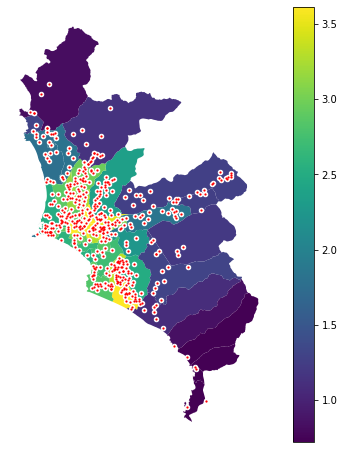

In [142]:
plot_access_measure('gravity_value')

In [143]:
cs_access.access_df.head()

,pop,gravity_value
UBIGEO,,
070101,451260,2.502952
070102,74851,2.891505
070103,42240,3.446474
070104,61417,2.895518
070105,3829,1.820587


In [144]:
score = cs_access.access_df
final_score = lima.merge(score, on='UBIGEO', how='left')

In [145]:
final_score.head()

,NOMBDIST,UBIGEO,pop_x,geometry,pop_y,gravity_value
0,LURIGANCHO,150118,240814,"MULTIPOLYGON (((311910.061 8686607.855, 311961...",240814,1.274542
1,JESUS MARIA,150113,75359,"MULTIPOLYGON (((278196.597 8665493.090, 278177...",75359,2.971622
2,LIMA,150101,268352,"MULTIPOLYGON (((281207.034 8669236.772, 281263...",268352,3.744015
3,LINCE,150116,54711,"MULTIPOLYGON (((279248.264 8663924.769, 279250...",54711,2.879791
4,MIRAFLORES,150122,99337,"MULTIPOLYGON (((279342.600 8661206.946, 279340...",99337,2.552837


<AxesSubplot:>

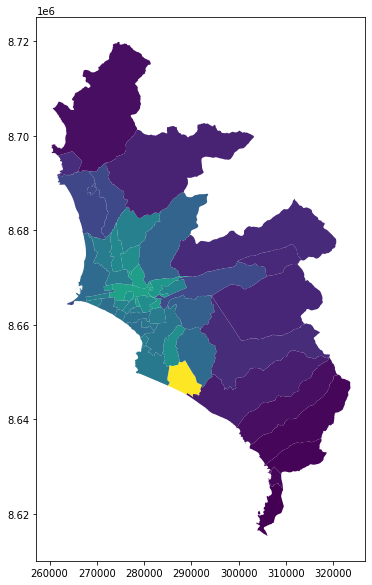

In [146]:
final_score.plot(column='gravity_value', figsize=(10,10))

In [147]:
final_score.to_file("lima_gravity_models.gpkg", layer='lima_gravity', driver="GPKG")

/home/ambarja/.local/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
A = Access(demand_df            = lima,
           demand_index         = 'UBIGEO',
           demand_value         = 'pob2017',
           supply_df            = cs,
           supply_index         = 'codigo',
           supply_value         = ['Medico','Odontologo'],
           cost_df              = cost_cs,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = cost_cs,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

In [ ]:
A.create_euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)

In [ ]:
A.cost_df

In [ ]:
A.demand_df = A.demand_df.to_crs(epsg = 32718)
A.supply_df = A.supply_df.to_crs(epsg = 32718)

In [ ]:
print(A.demand_df.crs)
print(A.supply_df.crs)

In [ ]:
fn30 = weights.step_fn({10 : 1, 20 : 0.68, 30 : 0.22})
fn60 = weights.step_fn({20 : 1, 40 : 0.68, 60 : 0.22})

In [ ]:
gaussian = weights.gaussian(20)

In [ ]:
gravity = weights.gravity(scale = 60, alpha = -1)

In [ ]:
A.weighted_catchment    (name = "gravity",  weight_fn = gravity)
A.fca_ratio             (name = "fca",      max_cost = 15)
A.fca_ratio             (name = "fca",      max_cost = 30)
A.fca_ratio             (name = "fca60",    max_cost = 60)
A.fca_ratio             (name = "fca90",    max_cost = 90)
A.two_stage_fca         (name = "2sfca",    max_cost = 60)
A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = fn30)
A.enhanced_two_stage_fca(name = "2sfca60",  weight_fn = fn60)
A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
A.three_stage_fca       (name = "3sfca")
A.raam(name = "raam", tau = 60)
A.raam(name = "raam30", tau = 30)

In [ ]:
A.access_df.head()

In [ ]:
# New web visualization with kepler -------------------- 
kepler_map = keplergl.KeplerGl(height=400)

In [ ]:
kepler_map.add_data(data = final_score, name="Puntaje de accesibilidad")

In [ ]:
kepler_map

In [ ]:
config = kepler_map.config

In [ ]:
kepler_map.save_to_html(file_name='index.html')